# Before you start: Install Tensorflow and Keras

This assignment requires to install Keras. Using Anaconda, this should be simple:

`conda install keras`

That's it. If you get any conda package conflits, it may be convenient to create a new conda environment:

`conda create -n tf2 tensorflow=2.3.0 jupyter python=3.7 matplotlib seaborn scikit-learn`

This will create a conda environment with the name `tf2` and install tensorflow 2 (including Keras), jupyter notebook, matplotlib, seaborn and python 3.7. You can switch to the newly created `tf2` environment by typing

`source activate tf2` 

And then run

`jupyter notebook`

in the same terminal to open a jupyter notebook. 

_Note that after performing the install, you need to restart this notebook for the changes to take effect._

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)
print(keras.__version__)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Keras imports
from tensorflow.keras import backend as K
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D

2.0.0
2.2.4-tf


In [2]:
def prepare_data(use_classes = [0,8], return_shape_y='matrix',return_shape_x='flat',n_trainex_per_class='all'):
    '''Wrapper function that returns preprocessed training and validation data from the famous MNIST data set
    
    Note: Class labels are _always_ re-assigned such that the class labels returned are in range 0:n_classes 
    (i.e. if you request classes 2 and 8, you will still get labels 0 and 1 out)
    
    input arguments:
        use_classes: list of integers (values from 0-9 in any order)
        Only examples from the classes in this list will be returned
        
        return_shape_y: string ('matrix' or 'vector')
        'matrix' will return a one-hot class encoding of the labels with shape (n_examples x n_classes)
        'vector' will return a list of labels with length (n_examples)
        
        return_shape_x: string ('flat', 'channels' or 'image')
        'flat' will return input images as flattened arrays (n_examples x n_pixels)
        'image' will return input images as stacked images (n_examples x n_rows x n_columns)
        'channels' will return input images as stacked images with an additional channel dimension that tensorflow requires for convolutions
        shape for 'channels' will be either (n_examples x n_rows x n_columns x 1) or (n_examples x 1 x n_rows x n_columns), depending on your keras system settings
        
        n_trainex_per_class: int (values up to 5421 will work (5421 = number of example in smallest class))
        
        
    returns:
        (x_train, y_train): tuple of arrays
            x_train: training set images with shape defined by return_shape_x
            y_train: training set labels with shape defined by return_shape_y
        
        (x_test, y_test): tuple of arrays
            x_test: test set images with shape defined by return_shape_x
            y_test: test set labels with shape defined by return_shape_y
        
        num_classes: int
            number of classes used
        '''
    
    
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # input image dimensions
    img_rows, img_cols = 28, 28

    # find and use only examples of chosen classes
    train_idx = np.isin(y_train,use_classes)
    test_idx = np.isin(y_test,use_classes)
    x_train = x_train[train_idx,:,:]
    y_train = y_train[train_idx]
    x_test = x_test[test_idx,:,:]
    y_test = y_test[test_idx]
    
    # if required, use fewer training examples per class
    if not n_trainex_per_class=='all':
        y_smaller = []
        x_smaller = []
        for c in use_classes:
            class_idx = np.where(y_train==c)[0][:n_trainex_per_class]
            y_smaller.append(y_train[class_idx])
            x_smaller.append(x_train[class_idx,:,:])
        y_train = np.concatenate(y_smaller)
        x_train = np.concatenate(x_smaller)

    # make new class labels that are 0:n_classes (needed for later use of 'keras.utils.to_categorical')
    new_class_ids_mapping = {old_id:new_id for new_id,old_id in enumerate(use_classes)}
    num_classes = len(use_classes)
    y_test = np.array([new_class_ids_mapping[y] for y in y_test])
    y_train = np.array([new_class_ids_mapping[y] for y in y_train])

    # normalize images and print shape
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    # if requested convert class vectors to binary class matrices
    if return_shape_y=='matrix':
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)
    # otherwise return as vector
    elif return_shape_y=='vector':
        pass
    else:        
        raise Exception('unknown return_shape_y')
    
    if return_shape_x=='flat':
        # flatten image data
        x_train = x_train.reshape(len(y_train), img_rows*img_cols)
        x_test = x_test.reshape(len(y_test), img_rows*img_cols)

    elif return_shape_x =='channels':
        # reshape to add channel dimension (being aware of the keras system setting)
        if K.image_data_format() == 'channels_first':
            x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
            x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
            x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)
    elif return_shape_x == 'image':
        pass
    
    else:
        raise Exception('unknown return_shape_x')

    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('x_train shape:', x_train.shape)
    print('y_train shape:', y_train.shape)
        
    return (x_train, y_train), (x_test, y_test), num_classes

# Task 0: Explore the dataset

We load the full MNIST dataset as provided by `tensorflow.keras.datasets.mnist` and plot 10 examples of each class in a 10x10 plot. 

In [3]:
# load data
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes=list(range(10)),return_shape_y='vector',return_shape_x='image',n_trainex_per_class=10)

100 train samples
10000 test samples
x_train shape: (100, 28, 28)
y_train shape: (100,)


In [4]:
# for later use
n_rows = x_train.shape[1]
n_clms = x_train.shape[2]

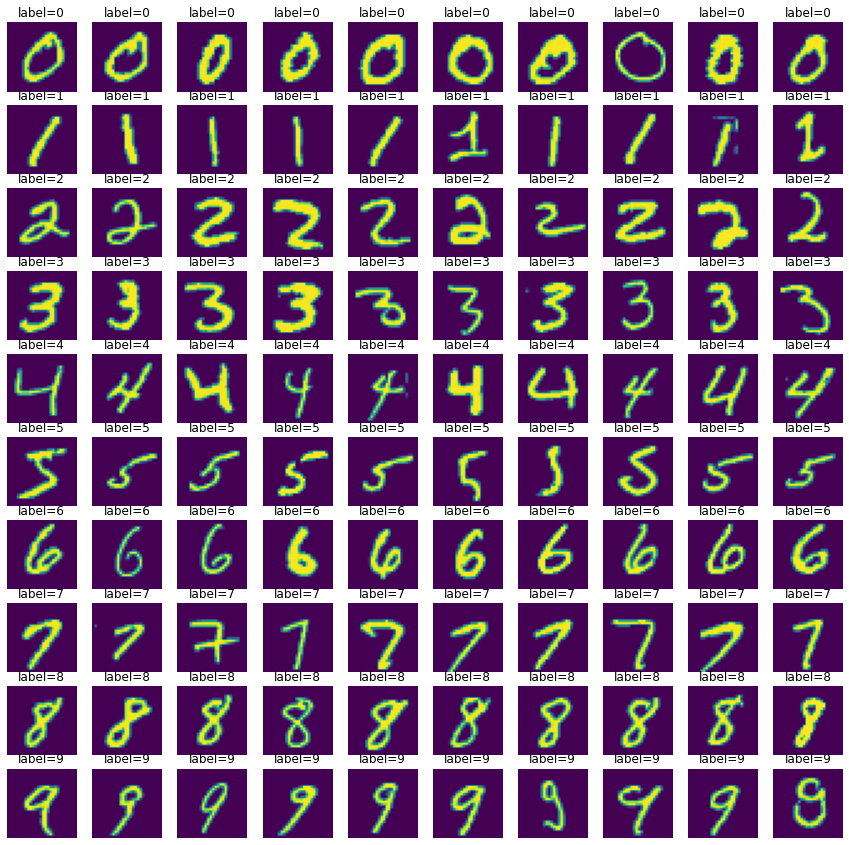

In [5]:
# display the first few examples
fig,axes = plt.subplots(10,10,figsize=(15,15))
axes=axes.flatten()
for i,ax in enumerate(axes):
    
    ax.imshow(x_train[i,:,:])
    ax.set_title('label=%u' % (y_train[i]))
    sns.despine()
    ax.axis('off')
plt.show()

# Task 1: LDA (15 points)

For the rest of the notebook, we will restrict ourselves to the classes `3` and `8`, and also to a subset of examples (`500` per class).

First, use Linear Discriminant Analysis to separate the classes. Here you will need to find a weight vector $\vec{w}$ so that the classes are optimally separated in the projections $p_i =   \vec{w}^T \vec{x}_i$ of data points $\vec{x}_i$.

In [6]:
classes = [3,8]
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes = classes,return_shape_y='vector',return_shape_x='flat',n_trainex_per_class=500)

1000 train samples
1984 test samples
x_train shape: (1000, 784)
y_train shape: (1000,)


Use the analytic solution to compute the optimal weights $\vec{w}$ from the training set data. 

Note: In cases like ours where $n_{features}$ isn't much smaller than $n_{samples}$, the within-class covariance matrix is not invertible. To fix this, we can add a small constant to the diagonal of it, which is equivalent to ridge regularization. Play a bit with the value of the pentaly to see its effect and find a value that gives good results.

You can rely on the fact that there is the same number of samples in each class (it simplifies some of the formulas).

In [7]:
def compute_lda_weights(x,y,alpha=1):
    '''function that computes regularized LDA weights for a two class problem
    
    input:
        x: training data -- array with shape (n_examples x n_features)
        y: training data class label -- flat array with length (n_examples)
        alpha: regularization strength -- float
        
    returns:
        m0: mean of the training examples of class 0 -- flat array with length (n_features)
        m1: mean of the training examples of class 1 -- flat array with length (n_features)
        mdiff: difference of the two class means -- flat array with length (n_features)
        w: regularized LDA weight vector -- flat array with length (n_features)
        '''
    
    # covariances per class
    cov0 = np.cov(x[y==0,:],rowvar=False)  
    cov1 = np.cov(x[y==1,:],rowvar=False)
    # means per class
    m0 = np.mean(x[y==0,:],axis=0)
    m1 = np.mean(x[y==1,:],axis=0)
    mdiff = m1-m0
    
    # invert within-class covariance matrix
    # add small constant variance to diagonal
    const = np.eye(n_rows*n_clms)*alpha
    S_within = cov0+cov1+const
    S_within_inv = np.linalg.inv(S_within)

    # get optimal projection vector w
    w = S_within_inv @ mdiff
    
    return m0,m1,mdiff,w

As  $\vec{w}$ has the dimensionality of our input data, we can interpret it as image with the same size as the training examples. Reshape the weight vector accordingly and plot the resulting 'weight image'. Describe and interpret the image.

In [8]:
def plot_weight_image(flat_data,im_dim,titlestr):
    '''Function that takes a flat vector with the same dimensionality as the input data 
    and plot it as an image of the shape of the original images'''
    
    # INSERT YOUR CODE HERE
    img = flat_data.reshape(im_dim)
    plt.imshow(img)
    plt.title(titlestr)
    plt.show()


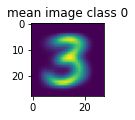

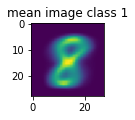

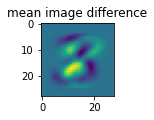

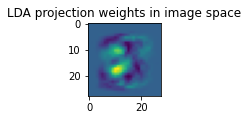

In [9]:
# compute weights
m0,m1,mdiff,w = compute_lda_weights(x_train,y_train,alpha=1)

# vizualize input data and resulting weight vector
#plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plot_weight_image(m0,(n_rows,n_clms),'mean image class 0')
plt.subplot(1,4,2)
plot_weight_image(m1,(n_rows,n_clms),'mean image class 1')
plt.subplot(1,4,3)
plot_weight_image(mdiff,(n_rows,n_clms),'mean image difference')
plt.subplot(1,4,4)
plot_weight_image(w,(n_rows,n_clms),'LDA projection weights in image space')
plt.show()

ADD YOUR ANSWER HERE: We can see clearly 3 and 8 in mean image class 0 and 1, and we can also see clearly both of 3 and 8 in mean image difference.LDA projection shows both 3 and 8. It not as clear as mean image difference, but we can see it catches more features than mean image difference.

Project the training data and the test data on $\vec{w}$. Visualize the class separation using a two-color histogram. Is the separation good? Is there a big difference between training and test data?

In [10]:
# Compute the projections for training and test data
x_train_proj = x_train @ w
x_test_proj = x_test @ w

In [11]:
def projection_histogram(x_proj,y,titlestr='',threshold='none'):
    '''Function that projects data x on a LDA weight vector w and plots the projection values separately by class
    
        input:
        x_proj: input data -- flat array with length (n_examples)
        y: class labels -- flat array with length (n_examples)
        titlestr: histogram title string
        threshold: threshold value (float) or 'none' (string) to not plot a threshold
    '''
    
    # INSERT YOUR CODE HERE
    plt.hist(x_proj[y==0], bins=20, alpha = 0.7)
    plt.hist(x_proj[y==1], bins=20, alpha = 0.7)
    plt.title(titlestr)
    plt.axvline(x=threshold)
    

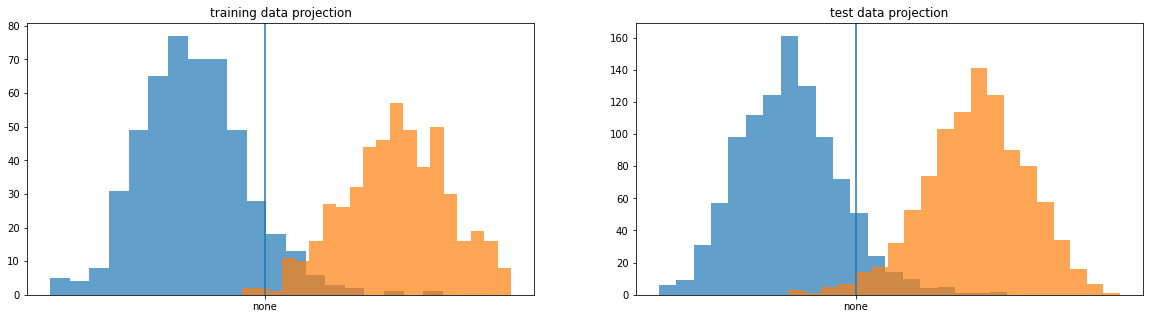

In [12]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
projection_histogram(x_train_proj,y_train,'training data projection')
plt.subplot(1,2,2)
projection_histogram(x_test_proj,y_test,'test data projection')
plt.show()

ADD YOU ANSWER HERE: Is the separation good? --quite well, but not very good. We can see some overlaps between 3 and 8 (blue and orange), which means LDA cannot completely separate 3 and 8. 
Is there a big difference between training and test data? --not big difference. The tops of the each mountain are almost same, and the shapes of the each mountain are quite similar each other.

Now we make class predictions based on the projections. Compute the threshold $c$ for projected values $p_i$ based on the training data (assigning each point to the class with higher posterior probability; assuming balanced classes, that's the same as higher likelihood). Print the value of $c$ and plot $c$ into the histograms of projected values you made before. You can use the fact that the classes are balanced.

Use $c$ to assign class labels for training and test set. Determine the classification errors on both datasets and print them. 

In [13]:
def compute_lda_weights_n(x,y,alpha=1):
    # covariances per class
    cov0 = np.cov(x[y==0,:],rowvar=False)  
    cov1 = np.cov(x[y==1,:],rowvar=False)
    # means per class
    m0 = np.mean(x[y==0,:],axis=0)
    m1 = np.mean(x[y==1,:],axis=0)
    mdiff = m1-m0
    
    # invert within-class covariance matrix
    # add small constant variance to diagonal
    const = np.eye(n_rows*n_clms)*alpha
    S_within = cov0+cov1+const
    S_within_inv = np.linalg.inv(S_within)

    # get optimal projection vector w
    w = S_within_inv @ mdiff
    
    return m0,m1,mdiff,S_within_inv,w

m0,m1,mdiff,S_within_inv,w = compute_lda_weights_n(x_train,y_train,alpha=1)

In [14]:
def opt_c_LDA(m0,m1,w):
    '''Compute the optimal threshold for LDA 
    
    input:
        m0, m1: mean vectors of the two classes -- flat array with length (n_features)
        w: weight vector of LDA -- flat array with length (n_features)
        
    output:
        c: the optimal threshold for LDA
         
    '''
    
    # INSERT YOUR CODE HERE
    #m0_vec = np.reshape(m0, (1, 784))
    #m0_vec_T = m0_vec.T
    #m1_vec = np.reshape(m1, (1, 784))
    #m1_vec_T = m1_vec.T
    #c = (m0_vec @ S_within_inv @ m0_vec_T - m1_vec @ S_within_inv @ m1_vec_T)/2
    c = (1/2)*(m0 + m1)@w
    
  
    return c

In [15]:
def score_LDA(x_proj,y,c):
    '''Compute the optimal threshold for LDA and the return the error 
    based on thresholding projected values
    
    input:
        x_proj: projected data -- flat array with length (n_examples)    
        y: class labels -- flat array with length (n_examples)
        c: optimal threshold for LDA - scalar
        
    output:
        y_hat: class label predicitons of LDA model -- flat array with length (n_examples)
        error: classification error
        
    '''
    
    # INSERT YOUR CODE HERE
    #make the array of y_hat, if xi_proj<c then y_hat =0 , else y_hat = 1
    y_hat = []
    for xi_proj in x_proj:
        if xi_proj<c:
            y_hat.append(0)
        else:
            y_hat.append(1)
            
    y_hat = np.array(y_hat)
    TorF = np.equal(y_hat, y).tolist()
    error = TorF.count(False)
    error = error/(len(TorF))
    
    return y_hat, error

0.615034152889903


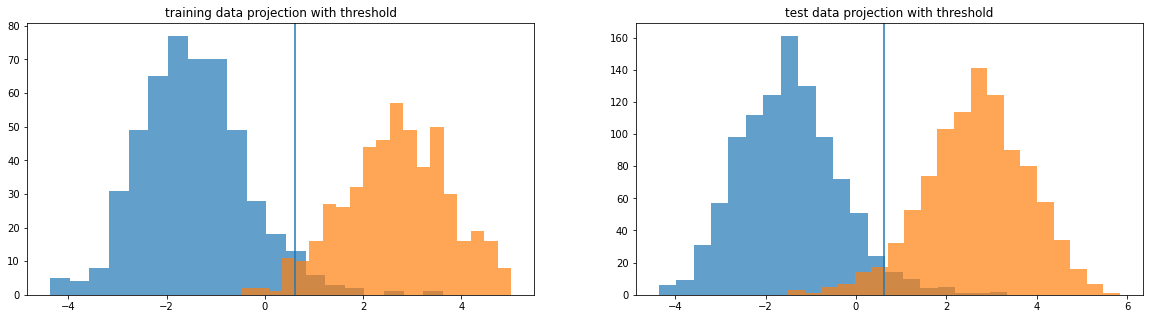

Training set error (LDA):  0.034
Test set error (LDA):      0.04032258064516129


In [16]:
c = opt_c_LDA(m0,m1,w)
print(c)

y_hat_train, error_train = score_LDA(x_train_proj,y_train,c)
y_hat_test, error_test = score_LDA(x_test_proj,y_test,c)

# show threshold in histograms
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
projection_histogram(x_train_proj,y_train,'training data projection with threshold',c)
plt.subplot(1,2,2)
projection_histogram(x_test_proj,y_test,'test data projection with threshold',c)
plt.show()

# print training and test set accuracy
print("Training set error (LDA): ", error_train)
print("Test set error (LDA):     ", error_test)

## Task 2: MNIST with Logistic Regression (15 points)

Now we will use logistic regression, again using `sklearn`. To make sure results are comparable, set the parameters `random_state=1` and `solver='saga'` when you define the models. Also, if you get convergence warnings choose a larger `max_iter` until all your models converge. You should not need more than 5000 iterations. Use the `n_jobs` parameter to control multiprocessing behavior (this can give a good speed-up for the later parts of this task if you have multiple CPU cores).

### Unregularized logistic regression
First, fit an unregularized logistic regression model using `sklearn`'s `LogisticRegression()`, and use `sklearn`'s in-built scoring function to get a test set error.

In [17]:
# define model
logreg_base = LogisticRegression(penalty='none',random_state=1,solver='saga',max_iter =  1900)

# fit
# INSERT YOUR CODE HERE
logreg_base.fit(x_train, y_train)

# score
print("Test set error (LogReg - no regularization) :", 1 - logreg_base.score(x_test,y_test))

Test set error (LogReg - no regularization) : 0.05241935483870963


### Ridge and Lasso with CV
Next, we will use Lasso and Ridge regularized logistic regression

Use `sklearn`'s `LogisticRegressionCV()` model to run a 10-fold crossvalidation over ten different log-spaced regularization strengths to find an optimal regularization strength; do this for both Lasso and Ridge regularization. Hint: Watch out for the parametrisation `sklearn` uses to pass the regularization strength. Note that this can take a few minutes to run.

In [18]:
# set shared hyperparameters
n_folds = 10
n_alphas = 10
max_iter = 5000

# define models
# fit models
# INSERT YOUR CODE HERE
logreg_lasso_cv = LogisticRegressionCV(cv = 10,penalty='l1',random_state=1,solver='saga',max_iter = 5000).fit(x_train, y_train)

In [19]:
# define models
# fit models
# INSERT YOUR CODE HERE
logreg_ridge_cv = LogisticRegressionCV(cv = 10,penalty='l2',random_state=1,solver='saga',max_iter = 5000).fit(x_train, y_train)

Plot crossvalidation curves for both lasso and ridge regularized logisitic regression: Plot regularization strength $\alpha$ vs. accuracy for each fold. Indicate the average accuracy across folds and mark the average score with optimal $\alpha$. In the code below, we already convert the sklearn parametrization of the regularization strength to a standard format.

In [20]:
def plot_cv_curves(alphas, cv_scores):
    '''Function that plots CV results: data from each fold/alpha combination,
    average over fold and a special mark for the optimal alpha.
    
    inputs: 
        alphas - flat array with alphas used in the CV, length (n_alphas)
        cv_scores - array accuracy values for each score/alpha combination, shape (n_folds x n_alphas)
    '''
    
    # INSERT YOUR CODE HERE
    for cv_score in cv_scores:
        plt.plot(alphas, cv_score)
        
    plt.xlabel('Regularized Parameter')
    plt.ylabel('Cross Validation Scores')


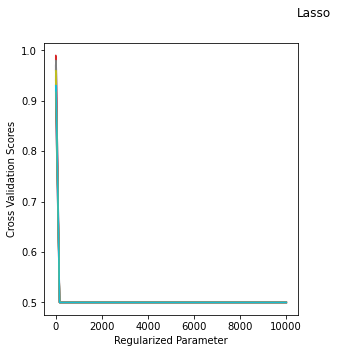

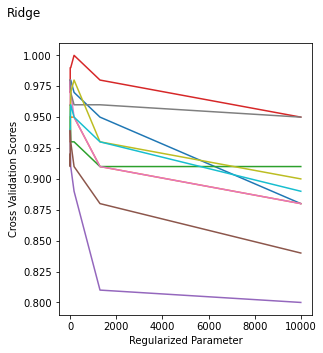

In [21]:
alphas_lasso = 1/logreg_lasso_cv.Cs_
alphas_ridge = 1/logreg_ridge_cv.Cs_
cv_scores_lasso = logreg_lasso_cv.scores_[1]
cv_scores_ridge = logreg_ridge_cv.scores_[1]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_cv_curves(alphas_lasso,cv_scores_lasso)
plt.suptitle('Lasso')
plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plot_cv_curves(alphas_ridge,cv_scores_ridge)
plt.suptitle('Ridge')
plt.show()

For both Lasso and Ridge, show how the 'weight images' change as a function of regularization strength. Plot one weight image per regularization strength value. Use `plt.colorbar()` to show the color-value mapping next to each plot so you can also see if the range of values changes. Describe and interpret what you observe.

In [22]:
def plot_weight_image_evolution(alphas,coefs_paths):
    '''function that plots weight image change with alphas'''

    fig,axes=plt.subplots(2,np.ceil(len(alphas)/2).astype(int),figsize=(15,5))

    # INSERT YOUR CODE HERE
    path_mean = np.mean(coefs_paths, axis=0)
    path_mean = np.delete(path_mean, 784, 1)
    im_dim = (n_rows,n_clms)
    for index, item in enumerate(path_mean):
        img = item.reshape(im_dim)
        axes[index // 5,index % 5].imshow(img)
        titlestr = "α = " + str(alphas[index])
        axes[index // 5,index % 5].set_title(titlestr)
        fig.colorbar(axes[index // 5,index % 5].imshow(img),ax = axes[index // 5,index % 5], orientation='vertical')

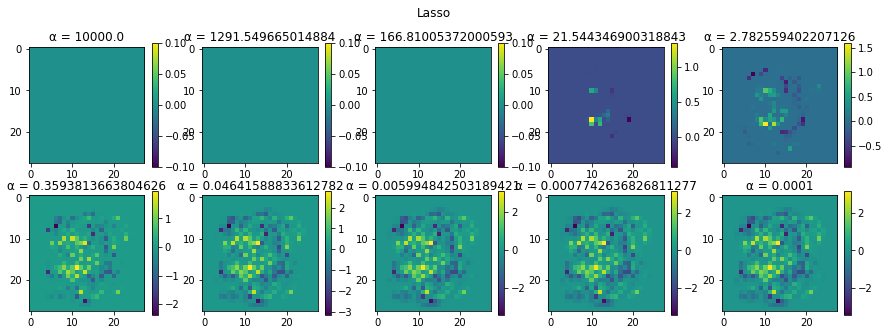

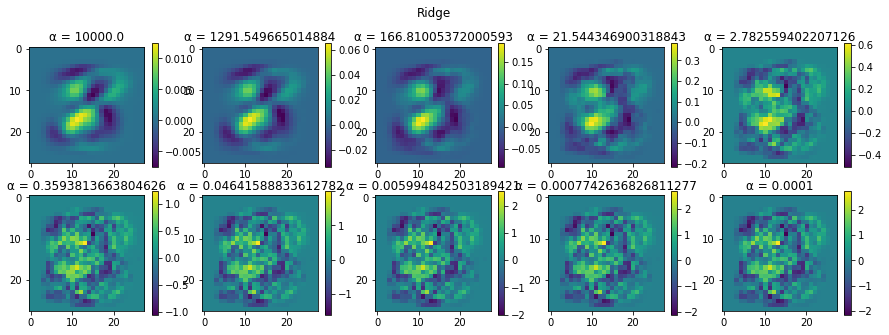

In [23]:
plot_weight_image_evolution(alphas_lasso,logreg_lasso_cv.coefs_paths_[1])
plt.suptitle('Lasso')
plt.show()

plot_weight_image_evolution(alphas_ridge,logreg_ridge_cv.coefs_paths_[1])
plt.suptitle('Ridge')
plt.show()

YOUR ANSWER HERE: In the lasso, we can see weight didn't work well because the weights express a few features. On the other hand, in the ridge, we can see clearly 3 and 8 in the Ridge alpha = 10000.0, 1291.54, 166.81, and the smaller alpha is the broader range of the features the wights express, which means weight images express wide range of the color according to the colourbar, and the place where non zero features are become broaden.

Compare the test error of the best lasso regularized logistic regression, the best ridge regularized logistic regression and the unregularized model.


In [24]:
logreg_ridge = logreg_ridge_cv
logreg_lasso = logreg_lasso_cv

In [25]:
print("Test set error (LogReg - no regularization) :", 1 - logreg_base.score(x_test,y_test))
print("Test set error (LogReg - ridge) :", 1 - logreg_ridge.score(x_test,y_test))
print("Test set error (LogReg - lasso) :", 1 - logreg_lasso.score(x_test,y_test))

Test set error (LogReg - no regularization) : 0.05241935483870963
Test set error (LogReg - ridge) : 0.03931451612903225
Test set error (LogReg - lasso) : 0.05393145161290325


Plot 'weight images' of the best lasso regularized logistic regression, the best ridge regularized logistic regression and the unregularized model. Describe and interpret the differences you observe. Also compare to the weight image obtained with LDA!

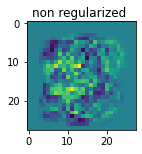

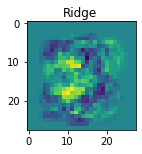

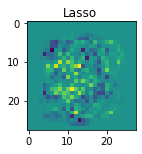

In [26]:
plt.figure(figsize=(2,2))
plt.suptitle('non regularized')
im_dim = (n_rows,n_clms)
img = logreg_base.coef_.reshape(im_dim)
plt.imshow(img)
plt.show()

plt.figure(figsize=(2,2))
plt.suptitle('Ridge')
im_dim = (n_rows,n_clms)
img = logreg_ridge.coef_.reshape(im_dim)
plt.imshow(img)
plt.show()

plt.figure(figsize=(2,2))
plt.suptitle('Lasso')
im_dim = (n_rows,n_clms)
img = logreg_lasso.coef_.reshape(im_dim)
plt.imshow(img)
plt.show()

YOUR ANSWER HERE:we can see the most clearly 3 and 8 in the Ridge best model, and the second most clean one is non regularised, and the worst one is Lasso. This order of how clear we can see is corresponding to the order of the Test set error.

## Task 3: MNIST with simple Keras Fully connected neural network  (10 points)

Now we use the Keras library that provides easy access to custom neural network implementation. If you look for a tutorial, try this:

https://keras.io/getting-started/sequential-model-guide/

In the two Keras tasks (Task 3 & 4), your job is to play with the hyperparameters and find an architecture that works and, in the best case, outperforms the more simple models from before that reached about 95% test set performance.

We start with a fully connected network - which is basically a logistic regression, with an added layers of hidden units.

In [27]:
# loading the data in a format suitable for Keras and fully connected networks (flat inputs)
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes = classes,return_shape_x='flat',return_shape_y='matrix',n_trainex_per_class=500)

1000 train samples
1984 test samples
x_train shape: (1000, 784)
y_train shape: (1000, 2)


Create a Keras model with two fully connected layers that takes our (flattened) images as input and outputs a softmax class score for both classes. Use `.summary()` to display the model's structure.

You can experiment with different sizes of the hidden layers, and you can also experiment with adding Dropout layers if you want (this was not covered in the lecture, so is strictly optional).

In [28]:
# hyperparameter
n_hidden_units = 1
# dropout_strength = 0.2

# define model
# INSERT YOUR CODE HERE
model_fcn = Sequential()
model_fcn.add(Dense(n_hidden_units, input_dim = 28*28, activation='relu'))
#model_fcn.add(Dense(128, activation='relu'))
model_fcn.add(Dense(2, activation='softmax'))

# print model structure
model_fcn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 785       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4         
Total params: 789
Trainable params: 789
Non-trainable params: 0
_________________________________________________________________


2022-01-10 12:55:36.756000: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-10 12:55:36.758279: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Set up the model optimization with `compile()`: use stochastic gradient descent (`SGD()`) with default settings (but you can also try adaptive optimizers, such as `Adam()` if you want). Use a crossentropy loss. Make sure Keras saves the `accuracy` metric for each epoch of the optimization.

Train the network on the training set for 100 epochs, and specify the test set as  `validation_data` in your call to `.fit()`. Make sure you save the output of `.fit()` to a variable.

In [29]:
# hyperparameters
batch_size = 128
epochs = 100


# choose loss and optimzer
# INSERT YOUR CODE HERE
model_fcn.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# fit model, return training history
# INSERT YOUR CODE HERE
#model_fcn.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))
history_fcn = model_fcn.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Train on 1000 samples, validate on 1984 samples
Epoch 1/100
1000/1000 [==============================] - 1s 691us/sample - loss: 0.6883 - accuracy: 0.6070 - val_loss: 0.6840 - val_accuracy: 0.5091
Epoch 2/100
1000/1000 [==============================] - 0s 132us/sample - loss: 0.6806 - accuracy: 0.5670 - val_loss: 0.6739 - val_accuracy: 0.6547
Epoch 3/100
1000/1000 [==============================] - 0s 114us/sample - loss: 0.6679 - accuracy: 0.6770 - val_loss: 0.6570 - val_accuracy: 0.6704
Epoch 4/100
1000/1000 [==============================] - 0s 112us/sample - loss: 0.6480 - accuracy: 0.6950 - val_loss: 0.6321 - val_accuracy: 0.6930
Epoch 5/100
1000/1000 [==============================] - 0s 111us/sample - loss: 0.6198 - accuracy: 0.7290 - val_loss: 0.5999 - val_accuracy: 0.7253
Epoch 6/100
1000/1000 [==============================] - 0s 112us/sample - loss: 0.5861 - accuracy: 0.7780 - val_loss: 0.5646 - val_accuracy: 0.7636
Epoch 7/100
1000/1000 [==============================] - 0

Report the test set error and loss.

In [30]:
# get final testset evaluation
# INSERT YOUR CODE HERE

print('\n<Evaluate>')
score = model_fcn.evaluate(x_test, y_test,verbose = 2)

print("Test set error (Dense NN):", 1 - score[1])
print("Test set loss (Dense NN): ", score[0])


<Evaluate>
1984/1 - 0s - loss: 0.2082 - accuracy: 0.9582
Test set error (Dense NN): 0.04183465242385864
Test set loss (Dense NN):  0.13630495659045636


Plot the trajectories of loss and accuracy for both test and training set, using the `history` object that `.fit()` returns. Describe how test and training loss behave over epochs. What do you observe and why?

In [31]:
def plot_history(history):
    '''Takes the history object returned by Keras' ´.fit()´ function and
    plots loss and accuracy curves for both training and validation set '''

     # INSERT YOUR CODE HERE
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
   
    epochs = range(len(acc))

    # show the graph
    plt.figure(figsize=(15, 10))
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 12  

    # plot accuracy values
    plt.plot(epochs, acc, color = "blue", linestyle = "solid", label = 'train acc')
    plt.plot(epochs, val_acc, color = "green", linestyle = "solid", label= 'valid acc')
 
    # plot loss values
    plt.plot(epochs, loss, color = "red", linestyle = "solid" ,label = 'train loss')
    plt.plot(epochs, val_loss, color = "orange", linestyle = "solid" , label= 'valid loss')
    plt.legend()
    plt.grid()
    plt.title('history')
    plt.xlabel('epochs')

    plt.show()

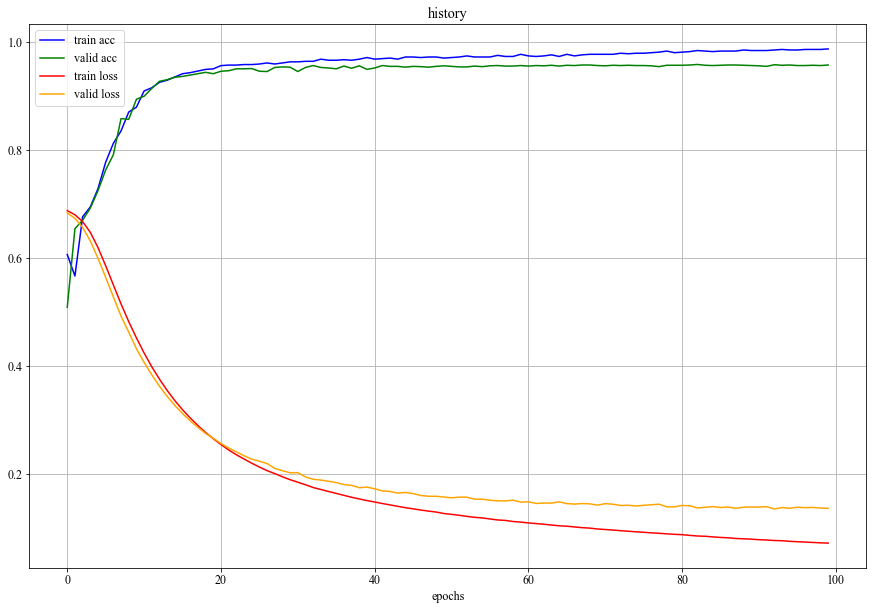

In [32]:
plot_history(history_fcn)

YOUR ANSWER HERE: The larger the number of epochs, the lower the loss and the higher the accuracy. This trend is more pronounced in the training data. In the case of the test data, the loss decreased and the accuracy improved as the number of epochs increased, but not as much as in the case of the training data.

## Task 4: MNIST with simple Keras CNN  (10 points)

In [33]:
# load the data in a conv net & keras friendly format
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes = classes,return_shape_x='channels',return_shape_y='matrix',n_trainex_per_class=500)

1000 train samples
1984 test samples
x_train shape: (1000, 28, 28, 1)
y_train shape: (1000, 2)


We defined a Keras model with convolutional layers and a fully connected top layer that outputs a softmax class score for both classes. Note that some of the parameters used below (number of hidden neurons, number of features, kernel size, etc) are not very good. Modify the existing network to obtain better results. Use `.summary()` to display the model's structure. Play with the hyperparameters such that you get roughly the same number of parameters as in the fully connected network above.

In [34]:
# hyperparameters
input_shape = x_train.shape[1:]
n_features_conv1 = 10 
n_features_conv2 = 12
n_features_top = 8
kernel_size = 11
pool_size = 2

#define model
model = Sequential()
model.add(Conv2D(n_features_conv1, kernel_size=(kernel_size, kernel_size),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(n_features_conv2, (kernel_size, kernel_size), activation='relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Flatten())
model.add(Dense(n_features_top, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# show model structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 18, 10)        1220      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 12)          14532     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 12)          0         
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1544      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 17,314
Trainable params: 17,314
Non-trainable params: 0
__________________________________________________

Configure the optimization as in Task 3 and train for 100 epochs as in Task 3.

In [35]:
batch_size = 128
epochs = 100

# choose loss and optimizer
# INSERT YOUR CODE HERE
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])


# fit model and return history
# INSERT YOUR CODE HERE
history_cnn = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Train on 1000 samples, validate on 1984 samples
Epoch 1/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.6126 - accuracy: 0.8130 - val_loss: 0.5225 - val_accuracy: 0.8523
Epoch 2/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.4286 - accuracy: 0.8890 - val_loss: 0.3346 - val_accuracy: 0.8871
Epoch 3/100
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.2637 - accuracy: 0.9220 - val_loss: 0.2351 - val_accuracy: 0.9037
Epoch 4/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.2067 - accuracy: 0.9280 - val_loss: 0.2716 - val_accuracy: 0.8881
Epoch 5/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.1735 - accuracy: 0.9360 - val_loss: 0.2348 - val_accuracy: 0.8962
Epoch 6/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.1630 - accuracy: 0.9440 - val_loss: 0.1674 - val_accuracy: 0.9425
Epoch 7/100
1000/1000 [==============================] - 3s 3ms/sample

As in Task 3, print test set loss and error and plot the trajectories of loss and accuracy for training and test set. Discuss the differences and similarities to the fully connected model. What is the best model over everything?


<Evaluate>
1984/1 - 1s - loss: 0.0728 - accuracy: 0.9829
Test set error (Conv NN): 0.017137110233306885
Test set loss (Conv NN):  0.05621807605852917


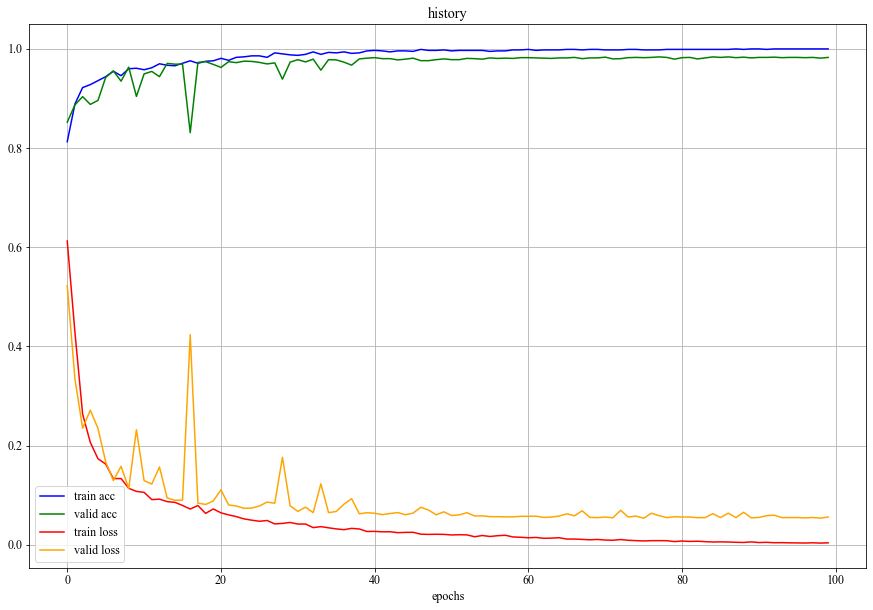

In [36]:
 # INSERT YOUR CODE HERE
print('\n<Evaluate>')
score = model.evaluate(x_test, y_test,verbose = 2)
print("Test set error (Conv NN):", 1 - score[1])
print("Test set loss (Conv NN): ", score[0])

plot_history(history_cnn)

As in Task 3, plot the trajectories of loss and accuracy for training and test set. Discuss the differences and similarities to the fully connected model. What is the best model over everything?

YOUR ANSWER HERE: Discuss the differences and similarities to the fully connected model. What is the best model over everything? 

Here is the result of fully connected network: 
1984/1 - 0s - loss: 0.2082 - accuracy: 0.9582
Test set error (Dense NN): 0.04183465242385864
Test set loss (Dense NN):  0.13630495659045636

Here is the result of convolutional network: 
1984/1 - 1s - loss: 0.0728 - accuracy: 0.9829
Test set error (Conv NN): 0.017137110233306885
Test set loss (Conv NN):  0.05621807605852917

When it comes to the speed of convergence, the speed of convergence of convolutional network is much more quickly than that of fully connected network. and both of the test set error and test set loss in the convolutional network is much better than these of fully connected network. I quess this is because we adjusted the fully connected model in order to make it as simple as possible. In stead of decreasing the loss and improving the accuracy, the simple fully connected network took much less time than convolutional network to run. I think the convolutional network is the best model totally because it has good performance of loss and accuracy.